In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from scipy.sparse.csgraph import laplacian
from graph_optimization import fdla_weights_symmetric, fmmc_weights, lmsc_weights, fastest_averaging_constant_weight, max_degree_weights, metropolis_hastings_weights

In [2]:
def generateP(A, kappa):
	dmax = np.max(np.sum(A, axis=0))
	L = laplacian(A, normed=False)
	M, _ = np.shape(A)
	I = np.eye(M)

	P = I - (kappa/dmax) * L

	return P, get_rho(P)

def get_rho(P):
	n = P.shape[0]
	_P = P - np.ones((n, n)) * (1/n)
	l = np.abs(np.linalg.eigvals(_P))
	l = l[1 - l > 1e-5]
	return np.max(l)

Connected: True
Nodes:  50
Edges:  200


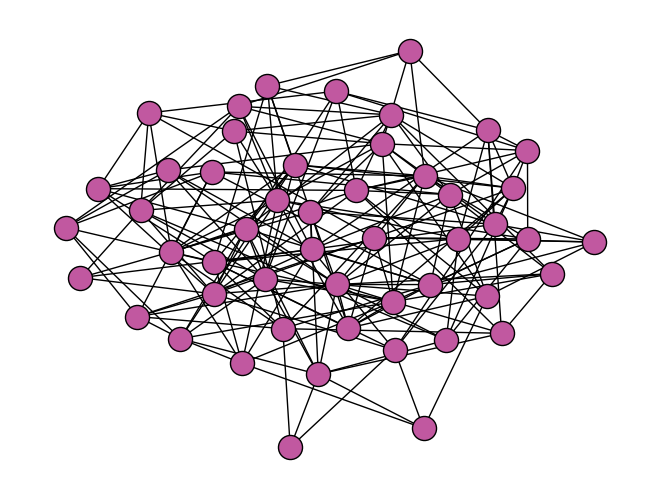

In [10]:
G = nx.gnm_random_graph(n=50, m=200)

print("Connected:", nx.is_connected(G))
print("Nodes: ", G.number_of_nodes())
print("Edges: ", G.number_of_edges())
nx.draw(G, node_color="#c158a0", edgecolors="black", pos=nx.kamada_kawai_layout(G))
np.save(f'data/saved_networks/large_50_adj.npy', nx.to_numpy_array(G))
np.save(f'data/saved_networks/large_50_inc.npy', np.asarray(nx.linalg.graphmatrix.incidence_matrix(G, oriented=True).todense()))


Connected: True
Nodes:  21
Edges:  48
Connected: True
Nodes:  21
Edges:  48


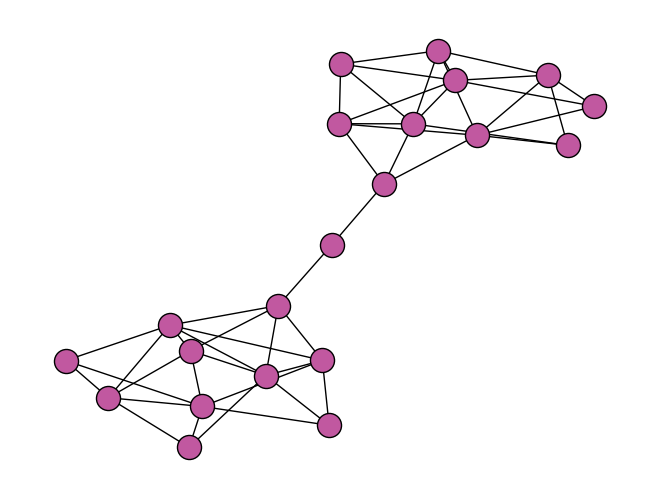

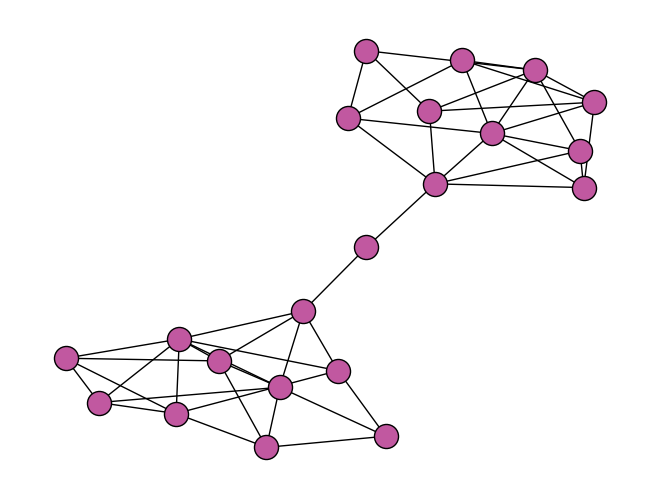

In [3]:
seeds = [80967431686, 29756843169]

for i, seed in enumerate(seeds):
	G0 = nx.erdos_renyi_graph(10, 0.4, seed=seed)
	G = nx.disjoint_union(G0, G0)
	G.add_node(20)
	G.add_edge(9, 20)
	G.add_edge(20, 17)

	print("Connected:", nx.is_connected(G))
	print("Nodes: ", G.number_of_nodes())
	print("Edges: ", G.number_of_edges())

	fig = plt.figure()
	nx.draw(G, node_color="#c158a0", edgecolors="black", pos=nx.kamada_kawai_layout(G))

	np.save(f'large{i}_adj.npy', nx.to_numpy_array(G))
	np.save(f'large{i}_inc.npy', np.asarray(nx.linalg.graphmatrix.incidence_matrix(G, oriented=True).todense()))

In [4]:
# adjacency matrices
As = [
	np.load("large0_adj.npy"),
	np.load("large1_adj.npy"),
]

# corresponding incidence matrices
Is = [
	np.load("large0_inc.npy"),
	np.load("large1_inc.npy"),
]

networks = [
	'Large network 0',
	'Large network 1',
]

np.set_printoptions(threshold=99999999999999999)

colors = [
	'tab:blue',
	'tab:orange',
	'tab:green',
	'tab:red',
	'tab:purple',
	'tab:brown',
	'tab:pink',
	'tab:gray',
	'tab:olive',
	'tab:cyan',
]

labels = [
	'κ = 0.02',
	'κ = 0.3',
	'κ = 0.9',
	'Constant-edge',
	'Maximum-degree',
	'Local-degree (MH)',
	'FMMC',
	'FDLA',
]

markers = [
	'o',
	'^',
	's',
	'x',
	'v',
	'*',
	'1',
	'D',
	'P',
]

np.set_printoptions(threshold=99999999999999999, linewidth=99999999999999999)

for mat_idx in range(len(As)):
	print(f'{networks[mat_idx]:15s} | {"rho":12s} | {"tau":12s}')
	Ps, rhos = [], []

	for k in [0.02, 0.3, 0.9]:
		P, rho = generateP(As[mat_idx], kappa=k)
		Ps.append(P)
		rhos.append(rho)
		print(f'{"kappa " + str(k):<15s} | {rho:.10f} | {1 / np.log(1 / rho):.10f}')

	# maximum degree
	alpha, _, P, rho = max_degree_weights(Is[mat_idx])
	rho = get_rho(P)
	Ps.append(P)
	rhos.append(rho)
	print(f'{"Max-degree":<15s} | {rho:.10f} | {1 / np.log(1 / rho):.10f}')

	# local degree (MH)
	_, P, rho = metropolis_hastings_weights(Is[mat_idx])
	rho = get_rho(P)
	Ps.append(P)
	rhos.append(rho)
	print(f'{"Local-degree":<15s} | {rho:.10f} | {1 / np.log(1 / rho):.10f}')

	# constant edge
	alpha, _, P, rho = fastest_averaging_constant_weight(Is[mat_idx])
	rho = get_rho(P)
	Ps.append(P)
	rhos.append(rho)
	print(f'{"Constant-edge":<15s} | {rho:.10f} | {1 / np.log(1 / rho):.10f}')

	# fmmc
	_, P, rho = fmmc_weights(Is[mat_idx])
	rho = get_rho(P)
	Ps.append(P)
	rhos.append(rho)
	print(f'{"FMMC":<15s} | {rho:.10f} | {1 / np.log(1 / rho):.10f}')

	# fdla
	_, P, rho = fdla_weights_symmetric(Is[mat_idx])
	rho = get_rho(P)
	Ps.append(P)
	rhos.append(rho)
	print(f'{"FDLA":<15s} | {rho:.10f} | {1 / np.log(1 / rho):.10f}\n\n')

	with open('p-matrices.txt', 'w+') as f:
		f.write(f'P matrices for {networks[mat_idx]}\n\n')
		for writeIdx, P in enumerate(Ps):
			f.write(labels[writeIdx] + '\n')
			f.write(str(P) + '\n')

Large network 0 | rho          | tau         
kappa 0.02      | 0.9997395281 | 3838.6855171086
kappa 0.3       | 0.9960929213 | 255.4453763569
kappa 0.9       | 0.9882787639 | 84.8142516579
Max-degree      | 0.9869764044 | 76.2826183497
Local-degree    | 0.9835467777 | 60.2769853444
Constant-edge   | 0.9809568497 | 52.0107175794
FMMC            | 0.9738356640 | 37.7177554065
FDLA            | 0.9692171603 | 31.9830263845


Large network 1 | rho          | tau         
kappa 0.02      | 0.9997635730 | 4229.1345853005
kappa 0.3       | 0.9964535944 | 281.4753442750
kappa 0.9       | 0.9893607831 | 93.4909887616
Max-degree      | 0.9881786479 | 84.0917011210
Local-degree    | 0.9851221515 | 66.7127703558
Constant-edge   | 0.9804159520 | 50.5603182369
FMMC            | 0.9734322484 | 37.1373732776
FDLA            | 0.9680644675 | 30.8103789261


